# Figure 5.A. Reduction in Wolbachia release ratios enabled by prior suppression
Author: Katie Tiley (katherine.tiley@lshtm.ac.uk) <br>
Date: 25 Oct 22 <br>
<br>
Note: in the code RIDL refers to 1gSLT, and IIT refers to Male Wolbachia release

In [1]:
from scipy.integrate import odeint
import numpy as np
import matplotlib as mat
import matplotlib.pyplot as plt
from scipy import integrate as sp
import seaborn as sns
from tabulate import tabulate
import pandas as pd
import time
import os

In [2]:
filepath = os.path.abspath(os.getcwd())

### 1. Set up model
Parameters:

In [2]:
# MOSQUITO
alphaO = 0.5  # rate that eggs hatch into larvae
alphaL = 0.18  # rate that larvae pupate
alphaP = 1  # rate that pupae eclose
phi = 500*(1/14)    # number eggs laid per mosquito per day
muO = 0.01    # daily death rate of eggs
muL = 0.1*alphaL    # daily death rate of larvae
muP = 0.1*alphaP     # pupae death rate
muM = 1/14     # adult mosquito death rate
muF = 1/14     # adult female mosquito death rate

# density-dependence via Bellows 1981:
AA = 1   # determines the density at which mortality remains proportionate
BB = 0.5   # determines the 'abruptness' of density-dependence

# WOLBACHIA
fCI = 0.012   # prop of cytoplasmic incompatibility that fails 'sigma'
MT = 0    # prop of wolbachia females that don't successfully maternally transfer 'omega'
c = 0.5      # mating competitiveness of released wolbachia males
cv = 1   #coverage of adulticide
e = 1.2      # relative mortality of wolbachia adults compared to wild adults
RR = 1       # release ratio of wolbachia eggs to wild type eggs
RRsupp = 1      # release ratio of wolbachia eggs to wild type eggs for suppression techniques

Initial conditions:
(equilibrium values previously defined in Supp)

In [3]:
O0 = 15947.608023052446
OW0 = 0
rOW0 = 0
OS0 = 0
L0 = 40271.71074193975
LW0 = 0
rLW0 = 0
LS0 = 0
P0 = 32.67541200187585
PW0 = 0
rPW0 = 0
PS0 = 0
M0 = 228.72754035145144
MW0 = 0
MS0 = 0
F0 = 228.72754035145144
FW0 = 0

Wolbachia release function:

In [4]:
start_wol = 200

def pulseN(t, start_wol=start_wol, releasenumber=5, frequency=14):    
    for i in range(0,releasenumber,1):
        if round(t) == start_wol + (frequency*i):
            return O0
    else:
        return 0

Suppression functions:

In [5]:
# IIT

def IIT(t, releasenumber=5, frequency=7, end=start_wol):
    for i in range(0,releasenumber,1):
        if round(t) == (end-frequency) - (frequency*i):
            return 0 #M0+F0
    else:
        return 0

In [6]:
# SIT / RIDL

switch = 0 #0 for SIT; 1 for RIDL

def SIT(t, releasenumber=5, frequency=7, end=start_wol):    
    for i in range(0,releasenumber,1):
        if round(t) == (end-frequency) - (frequency*i):
            return 0 #M0+F0
    else:
        return 0

In [7]:
# Environmental management

start_em=start_wol-(7*5)
stop_em=200
em_eff= 1 #0.526

def em(t):
    if round(t) < start_em:     #start
        return 1
    elif round(t) > stop_em:    #stop releases
        return 1
    else:
        return em_eff

In [8]:
# Larvicides (e.g. guppies)

start_lv=start_wol-(7*5)
stop_lv=200
lv_eff= 1 #5.95

def lv(t):
    if round(t) < start_lv:     #start
        return 1
    elif round(t) > stop_lv:    #stop releases
        return 1
    else:
        return lv_eff

In [9]:
# Adulticide

h = [] #needed to set adulticide pulses
for i in range(-4, 1, 1):
    h.append((start_wol-7) + (7*i))

def ad(t):    
    ad_eff = 0 #4.9
    if round(t) < h[0]:
        return 0
    elif round(t) > h[0]+0.01 and round(t) < h[1]:
        return 0
    elif round(t) > h[1]+0.01 and round(t) < h[2]:
        return 0
    elif round(t) > h[2]+0.01 and round(t) < h[3]:
        return 0
    elif round(t) > h[3]+0.01 and round(t) < h[4]:
        return 0
    elif round(t) > h[4]+0.01: # and round(t) < h[5]:
        return 0
#    elif round(t) > h[5]+0.01 and round(t) < h[6]:
#        return 0
#    elif round(t) > h[6]+0.01 and round(t) < h[7]:
#        return 0
#    elif round(t) > h[7]+0.01 and round(t) < h[8]:
#        return 0
#    elif round(t) > h[8]+0.01 and round(t) < h[9]:
#        return 0
#    elif round(t) > h[9]+0.01:
#        return 0
    else:
        return ad_eff

Model:

In [10]:
def deriv(y, t, fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch):
    
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = y
    
    #MOSQUITOES
    
    allfemales = 1+F+FW
    allmales = 1+M+MW+(MS*c)
    
    F_nothing = F + FW*MT 
    M_nothing = M + MW*fCI 
    
    F_wol = FW*(1-MT)
    
    #Eggs
    dOdt = em(t) * phi * F_nothing * M_nothing/allmales - alphaO*O - lv(t)*muO*O # eggs laid * females no-wol * (males no_wol / all males) (aka prop no-wol males)
    dOWdt = em(t) * phi * F_wol * (M+MW)/allmales - alphaO*OW - lv(t)*muO*OW 
    drOWdt = pulseN(t)*RR - alphaO*rOW - muO*rOW
    dOSdt = phi * allfemales * (MS*c)/allmales - alphaO*OS - muO*OS
    
    #Larvae
    dLdt =  alphaO*O - alphaL*L - lv(t)*muL*L
    dLWdt = alphaO*OW - alphaL*LW - lv(t)*muL*LW
    drLWdt = alphaO*rOW - alphaL*rLW - muL*rLW
    dLSdt = switch*alphaO*OS - alphaL*LS - muL*LS
    
    #Pupae 
    dPdt =  alphaL*(L/(1+((AA*(L+LW+LS))**BB))) - alphaP*P - lv(t)*muP*P 
    dPWdt = alphaL*(LW/(1+((AA*(L+LW+LS))**BB))) - alphaP*PW - lv(t)*muP*PW
    drPWdt = alphaL*(rLW/(1+((AA*(rLW))**BB))) - alphaP*rPW - muP*rPW 
    dPSdt = alphaL*(LS/(1+((AA*(L+LW+LS))**BB))) - alphaP*PS - muP*PS
        
    #Adult
    dMdt =  .5*alphaP*P - muM*M - ad(t)*M*cv
    dMWdt = IIT(t)*RRsupp + .5*alphaP*(PW+rPW) - muM*1.2*MW - ad(t)*MW*cv
    dMSdt = SIT(t)*RRsupp - muM*1.2*MS #+ .5*alphaP*PS remove for 1gSLT
    
    dFdt =  .5*alphaP*P - muF*F - ad(t)*F*cv
    dFWdt = .5*alphaP*(PW+rPW) - muF*1.2*FW - ad(t)*FW*cv

    return dOdt, dOWdt, drOWdt, dOSdt, dLdt, dLWdt, drLWdt, dLSdt, dPdt, dPWdt, drPWdt, dPSdt, dMdt, dMWdt, dMSdt, dFdt, dFWdt

Model prerequisites:

In [11]:
t = np.linspace(0, 1500, 1501) # grid of time points (in days)
y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # initial condition vector

Run model:

In [12]:
ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)

O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

Visual check all suppression functions are off and Wolbachia functions is on: (should see Wolbachia come to fixation from day 200)

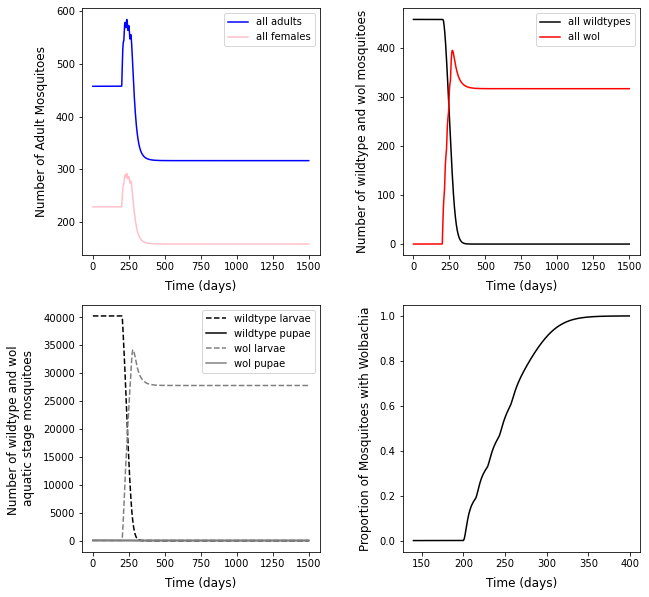

In [13]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=[10,10])

ax1.plot(t, F+FW+M+MW, 'blue', label='all adults')
ax1.plot(t, F+FW, 'pink', label='all females')
ax1.set_xlabel("Time (days)", fontsize=12, labelpad=8)
ax1.set_ylabel("Number of Adult Mosquitoes", fontsize=12, labelpad=8)
ax1.legend()

ax2.plot(t, M+F, 'black', label='all wildtypes')
ax2.plot(t, MW+FW, 'red', label='all wol')
ax2.set_xlabel("Time (days)", fontsize=12, labelpad=8)
ax2.set_ylabel("Number of wildtype and wol mosquitoes", fontsize=12, labelpad=8)
ax2.legend()

ax3.plot(t, L, 'black', linestyle='dashed', label='wildtype larvae')
ax3.plot(t, P, 'black', label='wildtype pupae')
ax3.plot(t, LW, 'grey', linestyle='dashed', label='wol larvae')
ax3.plot(t, PW, 'grey', label='wol pupae')
ax3.set_xlabel("Time (days)", fontsize=12, labelpad=8)
ax3.set_ylabel("Number of wildtype and wol \naquatic stage mosquitoes", fontsize=12, labelpad=8)
ax3.legend()

ax4.plot(t[140:400], (MW[140:400]+FW[140:400])/(MW[140:400]+FW[140:400]+M[140:400]+F[140:400]), 'black')
plt.xticks([150,200,250,300,350,400])
ax4.set_xlabel("Time (days)", fontsize=12, labelpad=8)
ax4.set_ylabel("Proportion of Mosquitoes with Wolbachia", fontsize=12, labelpad=8)


plt.subplots_adjust(wspace=.35)

Convert raw eggRR values into adultRR values:

In [15]:
RR_df = pd.read_csv(f'{filepath}/eggRR_adultRR.csv')

def convert_RR(RR):
    return  list(RR_df.loc[RR_df['egg RR'] == RR]['adult RR'])[0]

### 2.a. Data collection: minimum Wolbachia RR with each suppression for fixation within 6 months
### No suppression:

In [16]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo=[] #capture results here
start_wol=200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 5.29 seconds


In [17]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
RR_choosenosupp = RR_vec[sixmonth]
RR_choosenosupp = convert_RR(RR_choosenosupp)

## returns error if there is no fixation

In [18]:
# set up results dataframe
fig_df = pd.DataFrame({'Suppression type': 'No Suppression', '20%': 0, '50%': 0, '80%': 0, '%lit': RR_choosenosupp}, index=[0]) #0 indicates NA

fig_df

,Suppression type,%20,%50,%80,%lit
0,No Suppression,0,0,0,0.0775


### RIDL:

In [19]:
RIDL_df = pd.read_csv(f'{filepath}/RIDL_df.csv')

In [20]:
# switch on

switch = 1 #0 for SIT; 1 for RIDL

def SIT(t, releasenumber=5, frequency=7, end=start_wol):    
    for i in range(0,releasenumber,1):
        if round(t) == (end-frequency) - (frequency*i):
            return M0+F0
    else:
        return 0

20% efficacy:

In [21]:
RRsupp = list(RIDL_df.loc[RIDL_df['Target efficacy'] == 20, 'RRsupp value'])
RRsupp = RRsupp[0]

In [22]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo = [] #capture results here
start_wol = 200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 6.81 seconds


In [23]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
RIDL_choose20 = RR_vec[sixmonth]
RIDL_choose20 = convert_RR(RIDL_choose20)

50% efficacy:

In [24]:
RRsupp = list(RIDL_df.loc[RIDL_df['Target efficacy'] == 50, 'RRsupp value'])
RRsupp = RRsupp[0] 

In [25]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo = [] #capture results here
start_wol = 200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 6.66 seconds


In [26]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
RIDL_choose50 = RR_vec[sixmonth]
RIDL_choose50 = convert_RR(RIDL_choose50)

80% efficacy:

In [27]:
RRsupp = list(RIDL_df.loc[RIDL_df['Target efficacy'] == 80, 'RRsupp value'])
RRsupp = RRsupp[0]

In [28]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo = [] #capture results here
start_wol = 200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 6.69 seconds


In [29]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
RIDL_choose80 = RR_vec[sixmonth]
RIDL_choose80 = convert_RR(RIDL_choose80)

Literature efficacy:

In [30]:
RRsupp = list(RIDL_df.loc[RIDL_df['Target efficacy'] == 45, 'RRsupp value'])
RRsupp = RRsupp[0] 

In [31]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo = [] #capture results here
start_wol = 200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 6.62 seconds


In [32]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
RIDL_chooselit = RR_vec[sixmonth]
RIDL_chooselit = convert_RR(RIDL_chooselit)

Store results:

In [33]:
RIDL_vec = {'Suppression type': 'RIDL', '20%': RIDL_choose20, '50%': RIDL_choose50, '80%': RIDL_choose80, '%lit': RIDL_chooselit}
fig_df = fig_df.append(RIDL_vec, ignore_index=True)

fig_df

,Suppression type,%20,%50,%80,%lit
0,No Suppression,0.000,0.0000,0.0000,0.0775
1,RIDL,0.065,0.0425,0.0175,0.0425


In [34]:
# switch off

switch = 1 #0 for SIT; 1 for RIDL

def SIT(t, releasenumber=5, frequency=7, end=start_wol):    
    for i in range(0,releasenumber,1):
        if round(t) == (end-frequency) - (frequency*i):
            return 0 #M0+F0
    else:
        return 0

### SIT

In [35]:
SIT_df = pd.read_csv(f'{filepath}/SIT_df.csv')

In [36]:
# switch on

switch = 0 #0 for SIT; 1 for RIDL

def SIT(t, releasenumber=5, frequency=7, end=start_wol):    
    for i in range(0,releasenumber,1):
        if round(t) == (end-frequency) - (frequency*i):
            return M0+F0
    else:
        return 0

20% efficacy:

In [37]:
RRsupp = list(SIT_df.loc[SIT_df['Target efficacy'] == 20, 'RRsupp value'])
RRsupp = RRsupp[0]

In [38]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo = [] #capture results here
start_wol = 200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 6.77 seconds


In [39]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
SIT_choose20 = RR_vec[sixmonth]
SIT_choose20 = convert_RR(SIT_choose20)

50% efficacy:

In [40]:
RRsupp = list(SIT_df.loc[SIT_df['Target efficacy'] == 50, 'RRsupp value'])
RRsupp = RRsupp[0]

In [41]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo = [] #capture results here
start_wol = 200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 6.83 seconds


In [42]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
SIT_choose50 = RR_vec[sixmonth]
SIT_choose50 = convert_RR(SIT_choose50)

80% efficacy:

In [43]:
RRsupp = list(SIT_df.loc[SIT_df['Target efficacy'] == 80, 'RRsupp value'])
RRsupp = RRsupp[0]

In [44]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo = [] #capture results here
start_wol = 200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 6.76 seconds


In [45]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
SIT_choose80 = RR_vec[sixmonth]
SIT_choose80 = convert_RR(SIT_choose80)

Store results:

In [46]:
SIT_vec = {'Suppression type': 'SIT', '20%': SIT_choose20, '50%': SIT_choose50, '80%': SIT_choose80, '%lit': 0} # 0 indicates NA
fig_df = fig_df.append(SIT_vec, ignore_index=True)

fig_df

,Suppression type,%20,%50,%80,%lit
0,No Suppression,0.000,0.0000,0.0000,0.0775
1,RIDL,0.065,0.0425,0.0175,0.0425
2,SIT,0.065,0.0425,0.0175,0.0000


In [47]:
# switch off

switch = 0 #0 for SIT; 1 for RIDL

def SIT(t, releasenumber=5, frequency=7, end=start_wol):    
    for i in range(0,releasenumber,1):
        if round(t) == (end-frequency) - (frequency*i):
            return 0 #M0+F0
    else:
        return 0

### IIT

In [48]:
IIT_df = pd.read_csv(f'{filepath}/IIT_df.csv')

In [49]:
# switch on

def IIT(t, releasenumber=5, frequency=7, end=start_wol):
    for i in range(0,releasenumber,1):
        if round(t) == (end-frequency) - (frequency*i):
            return M0+F0
    else:
        return 0

20% efficacy:

In [50]:
RRsupp = list(IIT_df.loc[IIT_df['Target efficacy'] == 20, 'RRsupp value'])
RRsupp = RRsupp[0]

In [51]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo = [] #capture results here
start_wol = 200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 6.64 seconds


In [52]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
IIT_choose20 = RR_vec[sixmonth]
IIT_choose20 = convert_RR(IIT_choose20)

50% efficacy:

In [53]:
RRsupp = list(IIT_df.loc[IIT_df['Target efficacy'] == 50, 'RRsupp value'])
RRsupp = RRsupp[0]

In [54]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo = [] #capture results here
start_wol = 200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 6.67 seconds


In [55]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
IIT_choose50 = RR_vec[sixmonth]
IIT_choose50 = convert_RR(IIT_choose50)

80% efficacy:

In [56]:
RRsupp = list(IIT_df.loc[IIT_df['Target efficacy'] == 80, 'RRsupp value'])
RRsupp = RRsupp[0]

In [57]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo = [] #capture results here
start_wol = 200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 6.6 seconds


In [58]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
IIT_choose80 = RR_vec[sixmonth]
IIT_choose80 = convert_RR(IIT_choose80)

Literature efficacy:

In [59]:
RRsupp = list(IIT_df.loc[IIT_df['Target efficacy'] == 60, 'RRsupp value'])
RRsupp = RRsupp[0]

In [60]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo = [] #capture results here
start_wol = 200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 6.56 seconds


In [61]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
IIT_chooselit = RR_vec[sixmonth]
IIT_chooselit = convert_RR(IIT_chooselit)

Store results:

In [62]:
IIT_vec = {'Suppression type': 'IIT', '20%': IIT_choose20, '50%': IIT_choose50, '80%': IIT_choose80, '%lit': IIT_chooselit}
fig_df = fig_df.append(IIT_vec, ignore_index=True)

fig_df

,Suppression type,%20,%50,%80,%lit
0,No Suppression,0.0000,0.0000,0.0000,0.0775
1,RIDL,0.0650,0.0425,0.0175,0.0425
2,SIT,0.0650,0.0425,0.0175,0.0000
3,IIT,0.0625,0.0325,0.0025,0.0150


In [63]:
# switch off

def IIT(t, releasenumber=5, frequency=7, end=start_wol):
    for i in range(0,releasenumber,1):
        if round(t) == (end-frequency) - (frequency*i):
            return 0 #M0+F0
    else:
        return 0

### Environmental Management

In [64]:
EM_df = pd.read_csv(f'{filepath}/EM_df.csv')

In [65]:
# switch on

start_em = 165
stop_em = 200
em_eff = 1

def em(t):
    if round(t) < start_em:     #start
        return 1
    elif round(t) > stop_em:    #stop releases
        return 1
    else:
        return em_eff

20% efficacy:

In [66]:
em_eff = list(EM_df.loc[EM_df['Target efficacy'] == 20, 'Efficacy parameter'])
em_eff = em_eff[0]

In [67]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo = [] #capture results here
start_wol = 200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 5.63 seconds


In [68]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
EM_choose20 = RR_vec[sixmonth]
EM_choose20 = convert_RR(EM_choose20)

50% efficacy:

In [69]:
em_eff = list(EM_df.loc[EM_df['Target efficacy'] == 50, 'Efficacy parameter'])
em_eff = em_eff[0]

In [70]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo = [] #capture results here
start_wol = 200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 5.48 seconds


In [71]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
EM_choose50 = RR_vec[sixmonth]
EM_choose50 = convert_RR(EM_choose50)

80% efficacy:

In [72]:
em_eff = list(EM_df.loc[EM_df['Target efficacy'] == 80, 'Efficacy parameter'])
em_eff = em_eff[0]

In [73]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo = [] #capture results here
start_wol = 200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 5.51 seconds


In [74]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
EM_choose80 = RR_vec[sixmonth]
EM_choose80 = convert_RR(EM_choose80)

Literature efficacy:

In [75]:
em_eff = list(EM_df.loc[EM_df['Target efficacy'] == 47.4, 'Efficacy parameter'])
em_eff = em_eff[0]

In [76]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo = [] #capture results here
start_wol = 200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 5.47 seconds


In [77]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
EM_chooselit = RR_vec[sixmonth]
EM_chooselit = convert_RR(EM_chooselit)

Store results:

In [78]:
EM_vec = {'Suppression type': 'EM', '20%': EM_choose20, '50%': EM_choose50, '80%': EM_choose80, '%lit': EM_chooselit}
fig_df = fig_df.append(EM_vec, ignore_index=True)

fig_df

,Suppression type,%20,%50,%80,%lit
0,No Suppression,0.0000,0.0000,0.0000,0.0775
1,RIDL,0.0650,0.0425,0.0175,0.0425
2,SIT,0.0650,0.0425,0.0175,0.0000
3,IIT,0.0625,0.0325,0.0025,0.0150
4,EM,0.0725,0.0600,0.0475,0.0625


In [79]:
# switch off

start_em = 165
stop_em = 200
em_eff = 1

def em(t):
    if round(t) < start_em:     #start
        return 1
    elif round(t) > stop_em:    #stop releases
        return 1
    else:
        return em_eff

### Larvicide

In [80]:
LV_df = pd.read_csv(f'{filepath}/LV_df.csv')

In [81]:
# switch on

start_lv = start_wol-(7*5)
stop_lv = 200
lv_eff = 1 #5.95

def lv(t):
    if round(t) < start_lv:     #start
        return 1
    elif round(t) > stop_lv:    #stop releases
        return 1
    else:
        return lv_eff

20% efficacy:

In [82]:
lv_eff = list(LV_df.loc[LV_df['Target efficacy'] == 20, 'Efficacy parameter'])
lv_eff = lv_eff[0]

In [83]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo = [] #capture results here
start_wol = 200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 5.63 seconds


In [84]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
LV_choose20 = RR_vec[sixmonth]
LV_choose20 = convert_RR(LV_choose20)

50% efficacy:

In [85]:
lv_eff = list(LV_df.loc[LV_df['Target efficacy'] == 50, 'Efficacy parameter'])
lv_eff = lv_eff[0]

In [86]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo = [] #capture results here
start_wol = 200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 5.44 seconds


In [87]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
LV_choose50 = RR_vec[sixmonth]
LV_choose50 = convert_RR(LV_choose50)

80% efficacy:

In [88]:
lv_eff = list(LV_df.loc[LV_df['Target efficacy'] == 80, 'Efficacy parameter'])
lv_eff = lv_eff[0]

In [89]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo = [] #capture results here
start_wol = 200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 5.51 seconds


In [90]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
LV_choose80 = RR_vec[sixmonth]
LV_choose80 = convert_RR(LV_choose80)

Literature efficacy:

In [91]:
lv_eff = list(LV_df.loc[LV_df['Target efficacy'] == 45, 'Efficacy parameter'])
lv_eff = lv_eff[0]

In [92]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo = [] #capture results here
start_wol = 200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 5.4 seconds


In [93]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
LV_chooselit = RR_vec[sixmonth]
LV_chooselit = convert_RR(LV_chooselit)

Store results:

In [94]:
LV_vec = {'Suppression type': 'LV', '20%': LV_choose20, '50%': LV_choose50, '80%': LV_choose80, '%lit': LV_chooselit}
fig_df = fig_df.append(LV_vec, ignore_index=True)

fig_df

,Suppression type,%20,%50,%80,%lit
0,No Suppression,0.0000,0.0000,0.0000,0.0775
1,RIDL,0.0650,0.0425,0.0175,0.0425
2,SIT,0.0650,0.0425,0.0175,0.0000
3,IIT,0.0625,0.0325,0.0025,0.0150
4,EM,0.0725,0.0600,0.0475,0.0625
5,LV,0.0725,0.0625,0.0475,0.0650


In [95]:
# switch off

start_lv = start_wol-(7*5)
stop_lv = 200
lv_eff = 1

def lv(t):
    if round(t) < start_lv:     #start
        return 1
    elif round(t) > stop_lv:    #stop releases
        return 1
    else:
        return lv_eff

### Adulticide

In [96]:
AD_df = pd.read_csv(f'{filepath}/AD_df.csv')

In [97]:
# switch on

h = [] #needed to set adulticide pulses
for i in range(-4, 1, 1):
    h.append((start_wol-7) + (7*i))

def ad(t):    
    if round(t) < h[0]:
        return 0
    elif round(t) > h[0]+0.01 and round(t) < h[1]:
        return 0
    elif round(t) > h[1]+0.01 and round(t) < h[2]:
        return 0
    elif round(t) > h[2]+0.01 and round(t) < h[3]:
        return 0
    elif round(t) > h[3]+0.01 and round(t) < h[4]:
        return 0
    elif round(t) > h[4]+0.01:
        return 0
    else:
        return ad_eff

20% efficacy:

In [98]:
ad_eff = list(AD_df.loc[AD_df['Target efficacy'] == 20, 'Efficacy parameter'])
ad_eff = ad_eff[0]

In [99]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo = [] #capture results here
start_wol = 200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 6.62 seconds


In [100]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
AD_choose20 = RR_vec[sixmonth]
AD_choose20 = convert_RR(AD_choose20)

50% efficacy:

In [101]:
ad_eff = list(AD_df.loc[AD_df['Target efficacy'] == 50, 'Efficacy parameter'])
ad_eff = ad_eff[0]

In [102]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo = [] #capture results here
start_wol = 200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 6.71 seconds


In [103]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
AD_choose50 = RR_vec[sixmonth]
AD_choose50 = convert_RR(AD_choose50)

80% efficacy:

In [104]:
ad_eff = list(AD_df.loc[AD_df['Target efficacy'] == 80, 'Efficacy parameter'])
ad_eff = ad_eff[0]

In [105]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo = [] #capture results here
start_wol = 200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 6.69 seconds


In [106]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
AD_choose80 = RR_vec[sixmonth]
AD_choose80 = convert_RR(AD_choose80)

Literature efficacy:

In [107]:
ad_eff = list(AD_df.loc[AD_df['Target efficacy'] == 94, 'Efficacy parameter'])
ad_eff = ad_eff[0]
cv = list(AD_df.loc[AD_df['Target efficacy'] == 94, 'Coverage value'])
cv = cv[0]

In [108]:
start_time = time.time()

RR_vec = [0.00047,0.00134,0.00258,0.00418,0.00612,0.00842,0.01108,0.01408,0.01745,0.02115,0.0252,0.0296,0.03437,0.03945,0.04495,0.0507,0.0569,0.0634,0.0703,0.0775,0.085,0.093,0.10125,0.1098,0.1188,0.1281,0.1378,0.1478,0.1582,0.169,0.18,0.1915,0.203,0.215,0.2277,0.2405,0.2538,0.2672,0.2811,0.2953]
zoo = [] #capture results here
start_wol = 200

for i in RR_vec:
        
    RR = i
        
    # run the model
    t = np.linspace(0, 1500, 1501) # Grid of time points (in days)
    y0 = O0, OW0, rOW0, OS0, L0, LW0, rLW0, LS0, P0, PW0, rPW0, PS0, M0, MW0, MS0, F0, FW0 # Init condition vector
    ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, RRsupp, pulseN, IIT, SIT, em, lv, ad, cv, switch),hmax=1)
    O, OW, rOW, OS, L, LW, rLW, LS, P, PW, rPW, PS, M, MW, MS, F, FW = ret.T

    # get output
    total = MW+FW+M+F
    prop = (MW+FW)/(MW+FW+M+F)
    
    
    fix = np.argwhere(prop > 0.95)
    if sum(fix) > 0:
        min_fix = min(fix)-start_wol
        min_fix = min_fix.tolist()
    else:
        min_fix = [99999] #occurs if no fixation
        
    zoo.append(min_fix)

current_time = time.time()
elapsed_time = current_time - start_time
print('processing time:',round(elapsed_time,2),'seconds')

processing time: 6.52 seconds


In [109]:
zoo2 = [f for sublist in zoo for f in sublist] #flatten
sixmonth = next(x for x, val in enumerate(zoo2) if val <= 182.5) #within 6 months
AD_chooselit = RR_vec[sixmonth]
AD_chooselit = convert_RR(AD_chooselit)

Store results:

In [110]:
AD_vec = {'Suppression type': 'AD', '20%': AD_choose20, '50%': AD_choose50, '80%': AD_choose80, '%lit': AD_chooselit}
fig_df = fig_df.append(AD_vec, ignore_index=True)

,Suppression type,%20,%50,%80,%lit
0,No Suppression,0.0000,0.0000,0.0000,0.0775
1,RIDL,0.0650,0.0425,0.0175,0.0425
2,SIT,0.0650,0.0425,0.0175,0.0000
3,IIT,0.0625,0.0325,0.0025,0.0150
4,EM,0.0725,0.0600,0.0475,0.0625
5,LV,0.0725,0.0625,0.0475,0.0650
6,AD,0.0625,0.0450,0.0300,0.0475


In [111]:
fig_df.to_csv('RRfig_df.csv')

In [112]:
# switch off

h = [] #needed to set adulticide pulses
for i in range(-4, 1, 1):
    h.append((start_wol-7) + (7*i))

def ad(t):    
    ad_eff = 0
    if round(t) < h[0]:
        return 0
    elif round(t) > h[0]+0.01 and round(t) < h[1]:
        return 0
    elif round(t) > h[1]+0.01 and round(t) < h[2]:
        return 0
    elif round(t) > h[2]+0.01 and round(t) < h[3]:
        return 0
    elif round(t) > h[3]+0.01 and round(t) < h[4]:
        return 0
    elif round(t) > h[4]+0.01:
        return 0
    else:
        return ad_eff

### 2.b. Data formatting: minimum Wolbachia RR relative to no suppression for fixation within 6 months
#### To run if not running script all-through:

In [15]:
fig_df = pd.read_csv(f'{filepath}/RRfig_df.csv')

fig_df

,Suppression type,20%,50%,80%,%lit
0,No Suppression,0.0000,0.0000,0.0000,0.0775
1,RIDL,0.0650,0.0425,0.0175,0.0425
2,SIT,0.0650,0.0425,0.0175,0.0000
3,IIT,0.0625,0.0325,0.0025,0.0150
4,EM,0.0725,0.0600,0.0475,0.0625
5,LV,0.0725,0.0625,0.0475,0.0650
6,AD,0.0625,0.0450,0.0300,0.0475


In [12]:
a = list(fig_df.loc[fig_df['Suppression type'] == 'No Suppression', '%lit'])
a = a[0]
fig_df['20%'] = fig_df['20%']/a
fig_df['50%'] = fig_df['50%']/a
fig_df['80%'] = fig_df['80%']/a
fig_df['%lit'] = fig_df['%lit']/a
fig_df

,Suppression type,20%,50%,80%,%lit
0,No Suppression,0.000000,0.000000,0.000000,1.000000
1,RIDL,0.838710,0.548387,0.225806,0.548387
2,SIT,0.838710,0.548387,0.225806,0.000000
3,IIT,0.806452,0.419355,0.032258,0.193548
4,EM,0.935484,0.774194,0.612903,0.806452
5,LV,0.935484,0.806452,0.612903,0.838710
6,AD,0.806452,0.580645,0.387097,0.612903


### 2.c. Plot results for panel A

In [13]:
s1 = fig_df.loc[1]
s1 = s1.values.tolist()
s2 = fig_df.loc[2]
s2 = s2.values.tolist()
s3 = fig_df.loc[3]
s3 = s3.values.tolist()
s4 = fig_df.loc[4]
s4 = s4.values.tolist()
s5 = fig_df.loc[5]
s5 = s5.values.tolist()
s6 = fig_df.loc[6]
s6 = s6.values.tolist()

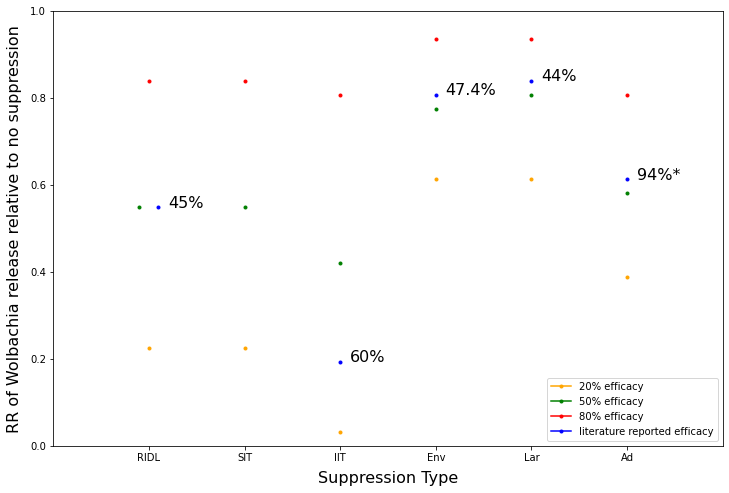

In [14]:
fig, ax1 = plt.subplots(figsize=(12,8))

#plt.margins(x=0,y=0)
ax1.plot(10, s1[3], marker=".", color='orange', label="20% efficacy")
ax1.plot(9, s1[2], marker=".", color='green', label="50% efficacy")
ax1.plot(10, s1[1], marker=".", color='red', label="80% efficacy")
ax1.plot(11, s1[4], marker=".", color='blue', label="literature reported efficacy")
ax1.text(12, s1[4], '45%', fontsize=16)
ax1.plot(20, s2[1], marker=".", color='red')
ax1.plot(20, s2[2], marker=".", color='green')
ax1.plot(20, s2[3], marker=".", color='orange')
ax1.plot(30, s3[1], marker=".", color='red')
ax1.plot(30, s3[2], marker=".", color='green')
ax1.plot(30, s3[3], marker=".", color='orange')
ax1.plot(30, s3[4], marker=".", color='blue')
ax1.text(31, s3[4], '60%', fontsize=16)
ax1.plot(40, s4[1], marker=".", color='red')
ax1.plot(40, s4[2], marker=".", color='green')
ax1.plot(40, s4[3], marker=".", color='orange')
ax1.plot(40, s4[4], marker=".", color='blue')
ax1.text(41, s4[4], '47.4%', fontsize=16)
ax1.plot(50, s5[1], marker=".", color='red')
ax1.plot(50, s5[2], marker=".", color='green')
ax1.plot(50, s5[3], marker=".", color='orange')
ax1.plot(50, s5[4], marker=".", color='blue')
ax1.text(51, s5[4], '44%', fontsize=16)
ax1.plot(60, s6[1], marker=".", color='red')
ax1.plot(60, s6[2], marker=".", color='green')
ax1.plot(60, s6[3], marker=".", color='orange')
ax1.plot(60, s6[4], marker=".", color='blue')
ax1.text(61, s6[4], '94%*', fontsize=16)
plt.xticks([10,20,30,40,50,60],['RIDL','SIT','IIT','Env','Lar','Ad'])
ax1.set_xlim(0,70)
ax1.set_ylim(0,1)
ax1.set_xlabel("Suppression Type",fontsize=16, labelpad=8)
ax1.set_ylabel("RR of Wolbachia release relative to no suppression",fontsize=16, labelpad=8)
ax1.legend(loc='lower right')
#ax1.set_title("Minimum RR required to reach 95% fixation of Wolbachia within 3 months of last release\n (normalised)")

#plt.savefig('Fig5A.jpeg', dpi=600, bbox_inches='tight',)